<center><h1>Kelly Choy</h1></center>
<br>
<center><font size="4">Text Vectorization, LDA Topic Modeling  </font></center>
<br>
<center><font size="4"> and predictive modeling</font></center>

### Clean data so it's only english reviews

import packages

In [2]:
import pandas as pd
import numpy as np
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import uniform, randint


In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
text_vector_dataset = pd.read_csv("text_vectorization.csv")
text_vector_dataset.head(3)

,business_id,name_x,city,stars_x,user_id,stars_y,text,cleaned_text
0,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,bFPdtzu11Oi0f92EAcjqmg,5,What a great addition to the Funk Zone! Grab ...,great addition funk zone grab bite grab tastin...
1,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,Ttb21DpWqphQMNSS5TXgMA,5,Possibly the best breakfast sandwich EVER. On...,possibly best breakfast sandwich ever biscuit ...
2,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,ha2Lv7WnxvdYnRsqwL1apQ,4,Pricey ( a ham and cheese croissant was $5.50)...,pricey ham cheese croissant 550 anywhere santa...


In [5]:
#Filter for English Reviews: ~runs about 6 minutes 49 seconds
#Assuming "cleaned_text" is the column containing the reviews
#Remove any missing or NaN values from the "cleaned_text" column.
text_vector_dataset.dropna(subset=["cleaned_text"], inplace=True)

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

#Filter for English reviews
english_reviews = text_vector_dataset[text_vector_dataset['cleaned_text'].apply(is_english)]

In [6]:
#testing to see the english_reviews dataframe
#decreases from 211748 rows to 208334. I went ahead to use this value because for each restaurant, there are already many rows of reviews so losing the non English rows can be okay.
#There may be some loss in data information, but we should have enough information to conduct this project/model
print(english_reviews)

                   business_id                name_x           city  stars_x  \
0       IDtLPgUrqorrpqSLdfMhZQ  Helena Avenue Bakery  Santa Barbara      4.0   
1       IDtLPgUrqorrpqSLdfMhZQ  Helena Avenue Bakery  Santa Barbara      4.0   
2       IDtLPgUrqorrpqSLdfMhZQ  Helena Avenue Bakery  Santa Barbara      4.0   
3       IDtLPgUrqorrpqSLdfMhZQ  Helena Avenue Bakery  Santa Barbara      4.0   
4       IDtLPgUrqorrpqSLdfMhZQ  Helena Avenue Bakery  Santa Barbara      4.0   
...                        ...                   ...            ...      ...   
211743  uriD7RFuHhLJeDdKaf0nFA            Pizza Guru  Santa Barbara      4.0   
211744  uriD7RFuHhLJeDdKaf0nFA            Pizza Guru  Santa Barbara      4.0   
211745  uriD7RFuHhLJeDdKaf0nFA            Pizza Guru  Santa Barbara      4.0   
211746  uriD7RFuHhLJeDdKaf0nFA            Pizza Guru  Santa Barbara      4.0   
211747  uriD7RFuHhLJeDdKaf0nFA            Pizza Guru  Santa Barbara      4.0   

                       user_id  stars_y

#### Transforming text data into TF-IDF Vectors

In [7]:
#using scikit-learn's TfidfVectorizer to transform your text data into TF-IDF vectors.
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(english_reviews['cleaned_text'])
print(tfidf_matrix)

  (0, 11014)	0.23831891090849536
  (0, 35031)	0.23512349697725982
  (0, 15236)	0.2178122594715346
  (0, 39381)	0.1267014852094443
  (0, 36010)	0.203869044278411
  (0, 2262)	0.17227915179869918
  (0, 15260)	0.20082983342995217
  (0, 9665)	0.37442610852292924
  (0, 44270)	0.15455883362527661
  (0, 4787)	0.11564275273986145
  (0, 34851)	0.11350054196349048
  (0, 13188)	0.18698768530526833
  (0, 33865)	0.13770291591674136
  (0, 18033)	0.07816501199144385
  (0, 23425)	0.19927951643370623
  (0, 39768)	0.19925780430944193
  (0, 5772)	0.17567588202502812
  (0, 18232)	0.41523066920181895
  (0, 45253)	0.24696672534418707
  (0, 17231)	0.25085993573728904
  (0, 2298)	0.2218305114304247
  (0, 18386)	0.08153825538452468
  (1, 18191)	0.5537890970421936
  (1, 27978)	0.3309234284598737
  (1, 5741)	0.42684904906822735
  :	:
  (208334, 18033)	0.09464155243563227
  (208334, 18386)	0.03290861591342676
  (208335, 19933)	0.30511240795759065
  (208335, 7612)	0.7046314528867963
  (208335, 18443)	0.201037904949

In [8]:
#runs for about 2 min 25 sec

num_topics = 10  # Choose the number of topics you want to identify - testing out 10 topics to check how the values form; this number can change around
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

LatentDirichletAllocation(random_state=42)

In [9]:
# Reshape the tfidf_matrix
tfidf_matrix = tfidf_matrix.toarray()  # Convert to dense matrix if it's sparse

#### Getting the lists for each topic

In [10]:
# Access the topics and their top words
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-10:][::-1]
    top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: pizza, sandwich, burger, great, good, place, salad, delicious, love, vegan
Topic 2: good, sauce, ordered, like, chicken, salad, fish, bread, flavor, dish
Topic 3: order, time, service, minute, table, place, like, good, dont, customer
Topic 4: ramen, great, wine, place, music, beer, good, hummus, love, pork
Topic 5: sushi, roll, thai, good, place, noodle, curry, great, chicken, rice
Topic 6: great, good, place, beer, service, friendly, drink, atmosphere, nice, happy
Topic 7: great, service, amazing, restaurant, delicious, dinner, wine, place, experience, excellent
Topic 8: view, great, clam, chowder, beach, place, good, room, seafood, service
Topic 9: taco, salsa, burrito, mexican, good, place, great, best, tortilla, chip
Topic 10: breakfast, coffee, egg, great, place, good, toast, delicious, brunch, french


In [11]:
topic_distribution = lda.transform(tfidf_matrix)
topic_distribution

array([[0.01870901, 0.01870825, 0.01870932, ..., 0.01870889, 0.0187092 ,
        0.51865716],
       [0.02761562, 0.0276095 , 0.02760931, ..., 0.02760666, 0.0276119 ,
        0.75151501],
       [0.2336172 , 0.01550899, 0.01550767, ..., 0.015507  , 0.01550872,
        0.64231026],
       ...,
       [0.01491073, 0.01490063, 0.86591702, ..., 0.01489687, 0.01489615,
        0.01489867],
       [0.44023982, 0.01090818, 0.01090049, ..., 0.01090067, 0.01090227,
        0.01089952],
       [0.81401391, 0.02066755, 0.02067542, ..., 0.02066284, 0.02066449,
        0.02066403]])

In [12]:
#check num of row of topic_distribution 
# Calculate the topic distribution for each review
topic_distribution = lda.transform(tfidf_matrix)

# Check the number of rows (documents) in topic_distribution
num_rows = topic_distribution.shape[0]
print("Number of rows in topic_distribution:", num_rows)

Number of rows in topic_distribution: 208336


In [13]:
#check the num of row for english-review dataframe
english_reviews.reset_index(drop=True, inplace=True)
# english_reviews = english_reviews.iloc[:-1]
english_reviews

,business_id,name_x,city,stars_x,user_id,stars_y,text,cleaned_text
0,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,bFPdtzu11Oi0f92EAcjqmg,5,What a great addition to the Funk Zone! Grab ...,great addition funk zone grab bite grab tastin...
1,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,Ttb21DpWqphQMNSS5TXgMA,5,Possibly the best breakfast sandwich EVER. On...,possibly best breakfast sandwich ever biscuit ...
2,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,ha2Lv7WnxvdYnRsqwL1apQ,4,Pricey ( a ham and cheese croissant was $5.50)...,pricey ham cheese croissant 550 anywhere santa...
3,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,OVLf6NVTi7noMP1qCKr76w,5,Are you kidding me? This is without a doubt so...,kidding without doubt best ive ever life bread...
4,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,2ykh0_q0uMLFtypLDVSqlg,2,"Super slow service, ""salads"" are not very good...",super slow service salad good really priced wo...
...,...,...,...,...,...,...,...,...
208331,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,Santa Barbara,4.0,o72LSEPHKu1oQcpXeIVlag,5,This is one of my new favorite pizza joints he...,one new favorite pizza joint santa barbara kno...
208332,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,Santa Barbara,4.0,u30sv3s4V2tz5VOgNQYtgg,4,Ordered vegan chicken and Daiya cheese and onl...,ordered vegan chicken daiya cheese waited 15 m...
208333,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,Santa Barbara,4.0,Mp97BPH2Y7O1DsFt6wFp4Q,1,This was the worst pizza I've ever had ever ea...,worst pizza ive ever ever eatenwe ordered simp...
208334,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,Santa Barbara,4.0,06egjh3nrEb7EXX1VYZOCg,5,One of the best pizzas in SB....seriously!!!\n...,one best pizza sbseriously regular spot friend...


In [14]:
#checking to see if there any NaN values
english_reviews.reset_index(drop=True, inplace=True)

# Check for NaN values in the DataFrame
nan_count = english_reviews.isna().sum().sum()

# Print the result
if nan_count > 0:
    print("english_reviews DataFrame contains NaN values.")
else:
    print("english_reviews DataFrame does not contain NaN values.")


english_reviews DataFrame does not contain NaN values.


In [15]:
# Create a new dataframe for topic distribution - each row represent a review
topic_distribution_df = pd.DataFrame(topic_distribution, columns=[f'topic_{i + 1}' for i in range(num_topics)])
topic_distribution_df
# Now both dataframes should have the same number of rows

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,0.018709,0.018708,0.018709,0.331671,0.018707,0.018710,0.018710,0.018709,0.018709,0.518657
1,0.027616,0.027610,0.027609,0.027604,0.027608,0.027608,0.027612,0.027607,0.027612,0.751515
2,0.233617,0.015509,0.015508,0.015508,0.015507,0.015519,0.015507,0.015507,0.015509,0.642310
3,0.018193,0.018194,0.018198,0.018192,0.018192,0.018191,0.018195,0.018190,0.018194,0.836260
4,0.026005,0.026003,0.026008,0.025999,0.026004,0.765969,0.026004,0.026002,0.026003,0.026002
...,...,...,...,...,...,...,...,...,...,...
208331,0.856581,0.015935,0.015936,0.015934,0.015935,0.015935,0.015935,0.015936,0.015936,0.015935
208332,0.855354,0.016070,0.016090,0.016066,0.016068,0.016071,0.016074,0.016070,0.016069,0.016070
208333,0.014911,0.014901,0.865917,0.014893,0.014894,0.014896,0.014897,0.014897,0.014896,0.014899
208334,0.440240,0.010908,0.010900,0.010898,0.010898,0.472554,0.010899,0.010901,0.010902,0.010900


In [16]:
#add the topic loading values for each review per restaurant
final_merged = pd.concat([english_reviews, topic_distribution_df], axis=1)
final_merged

,business_id,name_x,city,stars_x,user_id,stars_y,text,cleaned_text,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,bFPdtzu11Oi0f92EAcjqmg,5,What a great addition to the Funk Zone! Grab ...,great addition funk zone grab bite grab tastin...,0.018709,0.018708,0.018709,0.331671,0.018707,0.018710,0.018710,0.018709,0.018709,0.518657
1,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,Ttb21DpWqphQMNSS5TXgMA,5,Possibly the best breakfast sandwich EVER. On...,possibly best breakfast sandwich ever biscuit ...,0.027616,0.027610,0.027609,0.027604,0.027608,0.027608,0.027612,0.027607,0.027612,0.751515
2,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,ha2Lv7WnxvdYnRsqwL1apQ,4,Pricey ( a ham and cheese croissant was $5.50)...,pricey ham cheese croissant 550 anywhere santa...,0.233617,0.015509,0.015508,0.015508,0.015507,0.015519,0.015507,0.015507,0.015509,0.642310
3,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,OVLf6NVTi7noMP1qCKr76w,5,Are you kidding me? This is without a doubt so...,kidding without doubt best ive ever life bread...,0.018193,0.018194,0.018198,0.018192,0.018192,0.018191,0.018195,0.018190,0.018194,0.836260
4,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,2ykh0_q0uMLFtypLDVSqlg,2,"Super slow service, ""salads"" are not very good...",super slow service salad good really priced wo...,0.026005,0.026003,0.026008,0.025999,0.026004,0.765969,0.026004,0.026002,0.026003,0.026002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208331,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,Santa Barbara,4.0,o72LSEPHKu1oQcpXeIVlag,5,This is one of my new favorite pizza joints he...,one new favorite pizza joint santa barbara kno...,0.856581,0.015935,0.015936,0.015934,0.015935,0.015935,0.015935,0.015936,0.015936,0.015935
208332,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,Santa Barbara,4.0,u30sv3s4V2tz5VOgNQYtgg,4,Ordered vegan chicken and Daiya cheese and onl...,ordered vegan chicken daiya cheese waited 15 m...,0.855354,0.016070,0.016090,0.016066,0.016068,0.016071,0.016074,0.016070,0.016069,0.016070
208333,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,Santa Barbara,4.0,Mp97BPH2Y7O1DsFt6wFp4Q,1,This was the worst pizza I've ever had ever ea...,worst pizza ive ever ever eatenwe ordered simp...,0.014911,0.014901,0.865917,0.014893,0.014894,0.014896,0.014897,0.014897,0.014896,0.014899
208334,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,Santa Barbara,4.0,06egjh3nrEb7EXX1VYZOCg,5,One of the best pizzas in SB....seriously!!!\n...,one best pizza sbseriously regular spot friend...,0.440240,0.010908,0.010900,0.010898,0.010898,0.472554,0.010899,0.010901,0.010902,0.010900


In [17]:
#listing the topic columns
topic_columns = ['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']

# Create a new column 'selected_topic' with the topic number that has the highest value
final_merged['selected_topic'] = final_merged[topic_columns].idxmax(axis=1)

#extract just the topic number without the 'topic_' prefix
final_merged['selected_topic'] = final_merged['selected_topic'].str.replace('topic_', '').astype(int)
final_merged

,business_id,name_x,city,stars_x,user_id,stars_y,text,cleaned_text,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,selected_topic
0,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,bFPdtzu11Oi0f92EAcjqmg,5,What a great addition to the Funk Zone! Grab ...,great addition funk zone grab bite grab tastin...,0.018709,0.018708,0.018709,0.331671,0.018707,0.018710,0.018710,0.018709,0.018709,0.518657,10
1,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,Ttb21DpWqphQMNSS5TXgMA,5,Possibly the best breakfast sandwich EVER. On...,possibly best breakfast sandwich ever biscuit ...,0.027616,0.027610,0.027609,0.027604,0.027608,0.027608,0.027612,0.027607,0.027612,0.751515,10
2,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,ha2Lv7WnxvdYnRsqwL1apQ,4,Pricey ( a ham and cheese croissant was $5.50)...,pricey ham cheese croissant 550 anywhere santa...,0.233617,0.015509,0.015508,0.015508,0.015507,0.015519,0.015507,0.015507,0.015509,0.642310,10
3,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,OVLf6NVTi7noMP1qCKr76w,5,Are you kidding me? This is without a doubt so...,kidding without doubt best ive ever life bread...,0.018193,0.018194,0.018198,0.018192,0.018192,0.018191,0.018195,0.018190,0.018194,0.836260,10
4,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,2ykh0_q0uMLFtypLDVSqlg,2,"Super slow service, ""salads"" are not very good...",super slow service salad good really priced wo...,0.026005,0.026003,0.026008,0.025999,0.026004,0.765969,0.026004,0.026002,0.026003,0.026002,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208331,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,Santa Barbara,4.0,o72LSEPHKu1oQcpXeIVlag,5,This is one of my new favorite pizza joints he...,one new favorite pizza joint santa barbara kno...,0.856581,0.015935,0.015936,0.015934,0.015935,0.015935,0.015935,0.015936,0.015936,0.015935,1
208332,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,Santa Barbara,4.0,u30sv3s4V2tz5VOgNQYtgg,4,Ordered vegan chicken and Daiya cheese and onl...,ordered vegan chicken daiya cheese waited 15 m...,0.855354,0.016070,0.016090,0.016066,0.016068,0.016071,0.016074,0.016070,0.016069,0.016070,1
208333,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,Santa Barbara,4.0,Mp97BPH2Y7O1DsFt6wFp4Q,1,This was the worst pizza I've ever had ever ea...,worst pizza ive ever ever eatenwe ordered simp...,0.014911,0.014901,0.865917,0.014893,0.014894,0.014896,0.014897,0.014897,0.014896,0.014899,3
208334,uriD7RFuHhLJeDdKaf0nFA,Pizza Guru,Santa Barbara,4.0,06egjh3nrEb7EXX1VYZOCg,5,One of the best pizzas in SB....seriously!!!\n...,one best pizza sbseriously regular spot friend...,0.440240,0.010908,0.010900,0.010898,0.010898,0.472554,0.010899,0.010901,0.010902,0.010900,6


#### Summarize all the reviews and group by restruant name now. We want to get the most common topic # that arised for a specific restaurant

In [18]:
#finding the topic that matches best and assign it to a restaurant
final = pd.DataFrame(final_merged)

# Group by 'business_id'
grouped = final.groupby('business_id')['name_x'].first().reset_index()
grouped['city'] = final.groupby('business_id')['city'].first().values

# Add the 'stars_x' column to the grouped DataFrame
grouped['stars_x'] = final.groupby('business_id')['stars_x'].first().values

# Find the most common topic for each business
grouped['topic_selected'] = final.groupby('business_id')['selected_topic'].apply(lambda x: x.mode().iloc[0]).values
grouped

,business_id,name_x,city,stars_x,topic_selected
0,--onnLZrsCazmcy2P_7fcw,Sizzler,Goleta,3.0,3
1,-3AooxIkg38UyUdlz5oXdw,Chase Restaurant,Santa Barbara,3.0,3
2,-8iATYRnN46Km0_-ldx6cg,Pace food+drink,Santa Barbara,4.0,6
3,-9r8nAzWyRSLxBWt8uQOdA,Hana Kitchen,Isla Vista,3.0,5
4,-ALqLSTzkGDMscHdxA1NgA,Su Casa Fresh Mexican Grill,Santa Barbara,4.5,9
...,...,...,...,...,...
1156,zeAfmYy9b1gfUJLRBHm6vQ,Presto Pasta,Santa Barbara,4.0,2
1157,ziXR7sUrbKRCNeDqfjibUg,Rudy's Restaurant No 1,Santa Barbara,4.0,9
1158,zpuFEeAhrNzXPkOlBf5Kog,Outback Steakhouse,Goleta,3.0,3
1159,zu4p6IZLSVn2Noto-vcwzw,East Beach Grill,Santa Barbara,3.5,10


In [19]:
#testing if it was able to get the first row value. - it works (stars_x is the overall avg rating for the restaurant)
restaurant_name = "Helena Avenue Bakery"

# Locate the restaurant by 'name_x'
helena_ave_bakery = grouped[grouped['name_x'] == restaurant_name]

# Print the result
helena_ave_bakery

,business_id,name_x,city,stars_x,topic_selected
382,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,Santa Barbara,4.0,10


In [20]:
#print group dataframe to a csv file
grouped.to_csv('topics_per_place.csv', index=False)

## Create some visualizations to help with some analysis

#### Creating a histogram to see the topic distributions

In [21]:
# Get the count of restaurants for each topic and reindex to cover all topics from 1 to 10
topic_counts = grouped['topic_selected'].value_counts().reindex(range(1, 11), fill_value=0)

# Calculate the total number of restaurants across all topics
total_restaurants = topic_counts.sum()

# Display the count of restaurants for each topic and the total count
print(topic_counts)
print(f"Total number of restaurants: {total_restaurants}")

topic_selected
1     188
2      86
3     268
4       4
5     107
6      64
7     156
8      43
9     139
10    106
Name: count, dtype: int64
Total number of restaurants: 1161


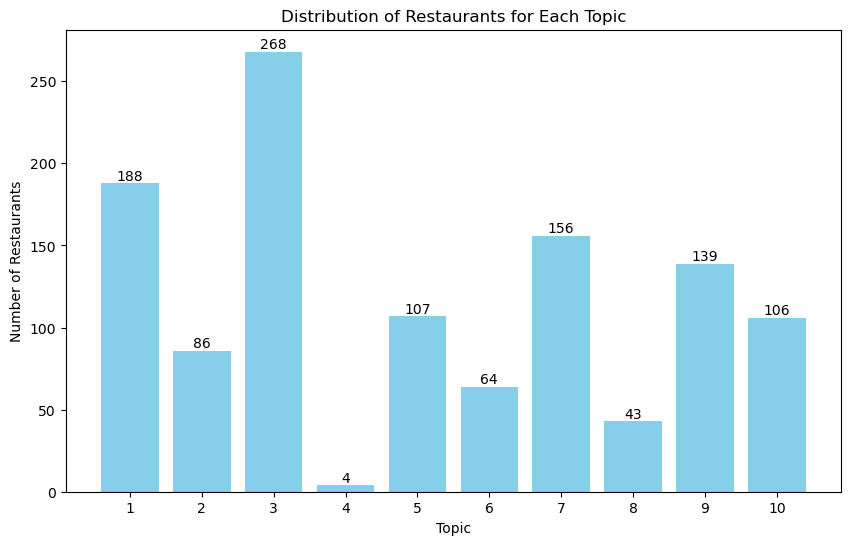

In [22]:
#bar chart to see the # of restaurant per each topic we did for Topic Modeling
plt.figure(figsize=(10, 6))
bars = plt.bar(topic_counts.index, topic_counts.values, color='skyblue')

plt.xlabel('Topic')
plt.ylabel('Number of Restaurants')
plt.title('Distribution of Restaurants for Each Topic')

plt.xticks(range(1, 11))  # Set x-axis ticks for all 10 topics

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')
plt.show()

### Seeing the topic selected with the star ratings 

generate a grouped bar chart showing the count of each topic selected for different star ratings. Each bar represents a star rating category, divided into segments representing different topics.

In [23]:
#checking the data type because of warning errors in code
print(grouped['stars_x'].dtype)  # Check the data type of 'stars_x'
print(grouped['stars_x'].unique())  # Check the data type of 'stars_x'
print(grouped['topic_selected'].dtype)  # Check the data type of 'topic_selected'
print(grouped['topic_selected'].unique())  # Print unique values in 'topic_selected'
grouped['topic_selected'] = grouped['topic_selected'].astype(str)


float64
[3.  4.  4.5 5.  2.5 3.5 2.  1.5]
int64
[ 3  6  5  9  7  1 10  8  2  4]


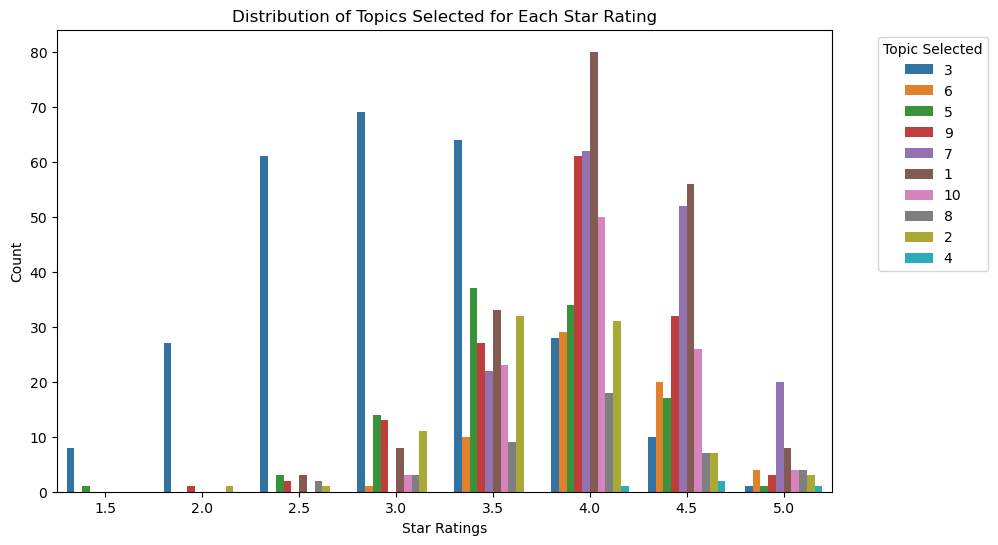

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(data=grouped, x='stars_x', hue='topic_selected')
plt.xlabel('Star Ratings')
plt.ylabel('Count')
plt.title('Distribution of Topics Selected for Each Star Rating')
plt.legend(title='Topic Selected', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [25]:
# Get the count of restaurants for each star rating 
# stars_x is the overall restaurant rating on yelp 
star_rating_counts = grouped['stars_x'].value_counts().sort_index()

# Display the count of restaurants for each star rating
print(star_rating_counts)

stars_x
1.5      9
2.0     29
2.5     72
3.0    122
3.5    257
4.0    394
4.5    229
5.0     49
Name: count, dtype: int64


### Number of restaurants for the star ratings

created a visual to see the distribution of # of restaurants and the star ratings (star_x)

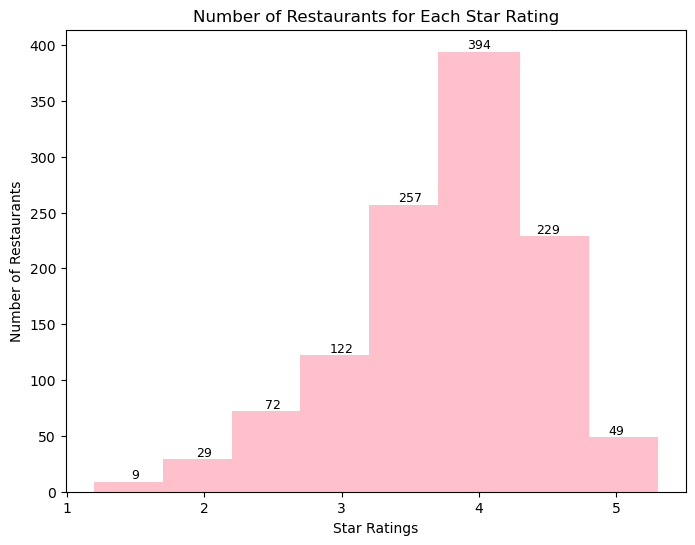

In [26]:
plt.figure(figsize=(8, 6))
bars = plt.bar(star_rating_counts.index, star_rating_counts.values, color='pink', width=0.6)
plt.xlabel('Star Ratings')
plt.ylabel('Number of Restaurants')
plt.title('Number of Restaurants for Each Star Rating')

# Annotate each bar with its count
for bar, count in zip(bars, star_rating_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count,
             ha='center', va='bottom', color='black', fontsize=9)

plt.show()

## Predictive Modeling: 

notes to remember:


1: fit model between star y (dependent var), x = the 10 topic loading value (topic 1-10) - using final_merged becuase that is on the individual level; stars_y is the individual review rating a user gave

2: assess the performance of that model using metrics

3: average topic loadings per restaurant

4: predict the stars values off of the loading values per restaurant to the actual star rating (star_x)

### Regression 

In [27]:
#this is using linear regression - just checking OLS regression results

# X contains the independent variables (10 different topic loading values)
X = final_merged[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']]
# y contains the dependent variable (star_y)
y = final_merged['stars_y']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                stars_y   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                 1.830e+04
Date:                Sun, 10 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:26:39   Log-Likelihood:            -2.9679e+05
No. Observations:              208336   AIC:                         5.936e+05
Df Residuals:                  208326   BIC:                         5.937e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.174e+11    4.2e+11      0.279      0.7

In [28]:
#Logistic Regression
#get the accuracy, precision, recall, f1 score; this is used for classification tasks
#converting to binary classification with a threshold: comparing each element in the 'stars_y' column with the mean value of the entire 'stars_y' column. 
y_binary = (final_merged['stars_y'] > final_merged['stars_y'].mean()).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Initialize and fit a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8212297206489393
Precision: 0.8448483352362144
Recall: 0.9187583892617449
F1 Score: 0.8802546337228929


In [29]:
#MSE is used for regression metrics - using linear regression
#'X' contains aggregated features and 'restaurant_rating' is the target variable
X = final_merged[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']]
# y contains the dependent variable (star_y)
y = final_merged['stars_y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model (use appropriate metrics)
# For example, calculate MSE
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.0182035240875138


#### Using XGBoost Regressor (slightly better option than linear)

In [30]:
# Features and Target variable
X = final_merged[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']]
y = final_merged['stars_y']  # Using individual review ratings as the target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)           #splitting the dataset into training and testing set

# Initialize and train the XGBoost regressor
model = XGBRegressor()
model.fit(X_train, y_train)

# Predict individual review ratings
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

#mean squared error is used to measure the avearge of the square of errors/deviations  between predicted and actual values

Mean Squared Error: 1.005156847878529


In [31]:
#getting more regression metrics to learn about the model
# Features and Target variable
X = final_merged[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']]
y = final_merged['stars_y']  # Using individual review ratings as the target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost regressor
model = XGBRegressor()
model.fit(X_train, y_train)

# Predict individual review ratings
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 1.005156847878529
Mean Absolute Error: 0.7750250226026352
R-squared: 0.4450176444324936
Root Mean Squared Error: 1.0025751083477632


#### averaging the loading values for each restaurant. 

In [32]:
# Group by 'Restaurant_ID' and calculate the mean for each topic
averaged_topics = final_merged.groupby('business_id')[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']].mean()

# Reset the index to make 'business_id' a column again
averaged_topics.reset_index(inplace=True)
averaged_topics

,business_id,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,--onnLZrsCazmcy2P_7fcw,0.195875,0.017390,0.461969,0.017389,0.017390,0.179735,0.047190,0.017393,0.028278,0.017389
1,-3AooxIkg38UyUdlz5oXdw,0.034695,0.169829,0.345281,0.023917,0.023700,0.058921,0.260133,0.033225,0.027669,0.022631
2,-8iATYRnN46Km0_-ldx6cg,0.126779,0.151082,0.162143,0.040800,0.036816,0.218878,0.155241,0.030737,0.049392,0.028132
3,-9r8nAzWyRSLxBWt8uQOdA,0.079172,0.060032,0.338593,0.019418,0.360542,0.030706,0.023160,0.023853,0.042391,0.022133
4,-ALqLSTzkGDMscHdxA1NgA,0.022942,0.028597,0.103061,0.037383,0.059519,0.071880,0.019931,0.031881,0.571432,0.053374
...,...,...,...,...,...,...,...,...,...,...,...
1156,zeAfmYy9b1gfUJLRBHm6vQ,0.146350,0.347333,0.189114,0.021035,0.037100,0.074508,0.094623,0.036281,0.031223,0.022432
1157,ziXR7sUrbKRCNeDqfjibUg,0.028625,0.040836,0.193391,0.022436,0.034139,0.039469,0.028335,0.052863,0.522301,0.037604
1158,zpuFEeAhrNzXPkOlBf5Kog,0.029074,0.291693,0.382725,0.023469,0.025186,0.099200,0.071407,0.034903,0.025395,0.016948
1159,zu4p6IZLSVn2Noto-vcwzw,0.039401,0.079764,0.164419,0.020224,0.021752,0.043968,0.021260,0.255693,0.053691,0.299830


#### predicting the star rating of the restaurant


In [33]:
#These are the predicting star rating for the restaurant
#Features for prediction (loading values for each topic) 
X_restaurants = averaged_topics[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']]
predicted_ratings = model.predict(X_restaurants)
predicted_ratings

array([3.5429695, 4.2274375, 3.8776941, ..., 3.0020683, 3.3511899,
       4.0174356], dtype=float32)

In [34]:
#checking the number of predictions we will be getting and it should match the num of restaurant: 1161
number_of_predictions = len(predicted_ratings)
print(f"Number of Predicted Ratings: {number_of_predictions}")

Number of Predicted Ratings: 1161


In [35]:
# Add predicted ratings to the original DataFrame 'averaged_topics'
averaged_topics['Predicted_Star_Rating'] = predicted_ratings
averaged_topics

,business_id,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,Predicted_Star_Rating
0,--onnLZrsCazmcy2P_7fcw,0.195875,0.017390,0.461969,0.017389,0.017390,0.179735,0.047190,0.017393,0.028278,0.017389,3.542969
1,-3AooxIkg38UyUdlz5oXdw,0.034695,0.169829,0.345281,0.023917,0.023700,0.058921,0.260133,0.033225,0.027669,0.022631,4.227437
2,-8iATYRnN46Km0_-ldx6cg,0.126779,0.151082,0.162143,0.040800,0.036816,0.218878,0.155241,0.030737,0.049392,0.028132,3.877694
3,-9r8nAzWyRSLxBWt8uQOdA,0.079172,0.060032,0.338593,0.019418,0.360542,0.030706,0.023160,0.023853,0.042391,0.022133,2.987151
4,-ALqLSTzkGDMscHdxA1NgA,0.022942,0.028597,0.103061,0.037383,0.059519,0.071880,0.019931,0.031881,0.571432,0.053374,4.389255
...,...,...,...,...,...,...,...,...,...,...,...,...
1156,zeAfmYy9b1gfUJLRBHm6vQ,0.146350,0.347333,0.189114,0.021035,0.037100,0.074508,0.094623,0.036281,0.031223,0.022432,3.388583
1157,ziXR7sUrbKRCNeDqfjibUg,0.028625,0.040836,0.193391,0.022436,0.034139,0.039469,0.028335,0.052863,0.522301,0.037604,3.808408
1158,zpuFEeAhrNzXPkOlBf5Kog,0.029074,0.291693,0.382725,0.023469,0.025186,0.099200,0.071407,0.034903,0.025395,0.016948,3.002068
1159,zu4p6IZLSVn2Noto-vcwzw,0.039401,0.079764,0.164419,0.020224,0.021752,0.043968,0.021260,0.255693,0.053691,0.299830,3.351190


#### Joining the predicted star rating with the original dataset (that include the restaurant rating)

In [36]:
# Create a new DataFrame with 'business_id	' and 'Predicted_Star_Rating' columns
predicted_df = pd.DataFrame({'business_id': averaged_topics['business_id'], 'Predicted_Star_Rating': predicted_ratings})

# Merge the predicted ratings with the original DataFrame 'final_merged'
predicted_star_rating = pd.merge(grouped, predicted_df, on='business_id', how='left')

# Round the 'Predicted_Star_Rating' column (tested keeping it rounded to the whole # is better than 1 and 2 decimal)
predicted_star_rating['Predicted_Star_Rating'] = predicted_star_rating['Predicted_Star_Rating'].round()
predicted_star_rating


,business_id,name_x,city,stars_x,topic_selected,Predicted_Star_Rating
0,--onnLZrsCazmcy2P_7fcw,Sizzler,Goleta,3.0,3,4.0
1,-3AooxIkg38UyUdlz5oXdw,Chase Restaurant,Santa Barbara,3.0,3,4.0
2,-8iATYRnN46Km0_-ldx6cg,Pace food+drink,Santa Barbara,4.0,6,4.0
3,-9r8nAzWyRSLxBWt8uQOdA,Hana Kitchen,Isla Vista,3.0,5,3.0
4,-ALqLSTzkGDMscHdxA1NgA,Su Casa Fresh Mexican Grill,Santa Barbara,4.5,9,4.0
...,...,...,...,...,...,...
1156,zeAfmYy9b1gfUJLRBHm6vQ,Presto Pasta,Santa Barbara,4.0,2,3.0
1157,ziXR7sUrbKRCNeDqfjibUg,Rudy's Restaurant No 1,Santa Barbara,4.0,9,4.0
1158,zpuFEeAhrNzXPkOlBf5Kog,Outback Steakhouse,Goleta,3.0,3,3.0
1159,zu4p6IZLSVn2Noto-vcwzw,East Beach Grill,Santa Barbara,3.5,10,3.0


In [37]:
#testing out the rounding values - testing this - does not seem to have many changes, so leaving it the raw values, will not further move with this approach
import pandas as pd
def custom_round(value):
    rounded_value = round(value * 2) / 2  # Round to the nearest 0.5
    
    # Ensure it has one decimal place
    return rounded_value if rounded_value % 1 == 0.0 else rounded_value

# Apply the custom rounding function to the 'Predicted_Star_Rating' column
predicted_star_rating['Predicted_Star_Rating'] = predicted_star_rating['Predicted_Star_Rating'].apply(lambda x: custom_round(x))

predicted_star_rating_testing = predicted_star_rating
predicted_star_rating_testing

,business_id,name_x,city,stars_x,topic_selected,Predicted_Star_Rating
0,--onnLZrsCazmcy2P_7fcw,Sizzler,Goleta,3.0,3,4.0
1,-3AooxIkg38UyUdlz5oXdw,Chase Restaurant,Santa Barbara,3.0,3,4.0
2,-8iATYRnN46Km0_-ldx6cg,Pace food+drink,Santa Barbara,4.0,6,4.0
3,-9r8nAzWyRSLxBWt8uQOdA,Hana Kitchen,Isla Vista,3.0,5,3.0
4,-ALqLSTzkGDMscHdxA1NgA,Su Casa Fresh Mexican Grill,Santa Barbara,4.5,9,4.0
...,...,...,...,...,...,...
1156,zeAfmYy9b1gfUJLRBHm6vQ,Presto Pasta,Santa Barbara,4.0,2,3.0
1157,ziXR7sUrbKRCNeDqfjibUg,Rudy's Restaurant No 1,Santa Barbara,4.0,9,4.0
1158,zpuFEeAhrNzXPkOlBf5Kog,Outback Steakhouse,Goleta,3.0,3,3.0
1159,zu4p6IZLSVn2Noto-vcwzw,East Beach Grill,Santa Barbara,3.5,10,3.0


In [38]:
#creating a csv file (results)
predicted_star_rating.to_csv('predicted_star_ratings.csv', index=False)

In [39]:
# Count the occurrences of each predicted star rating
rating_counts = predicted_star_rating['Predicted_Star_Rating'].value_counts().sort_index()

# Display the count for each predicted star rating
print("Count of Restaurants for Each Predicted Star Rating:")
for rating, count in rating_counts.items():
    print(f"Predicted Star Rating: {rating}, Count: {count}")

# Get the total sum of restaurants for all predicted star ratings
total_restaurants = rating_counts.sum()

# Display the total number of restaurants
print(f"Total Number of Restaurants: {total_restaurants}")

Count of Restaurants for Each Predicted Star Rating:
Predicted Star Rating: 2.0, Count: 48
Predicted Star Rating: 3.0, Count: 206
Predicted Star Rating: 4.0, Count: 750
Predicted Star Rating: 5.0, Count: 157
Total Number of Restaurants: 1161


In [40]:
#am interested in seeing what are the possible ratings that was given to the restaurants 
#'stars_x' is the column containing ratings
unique_ratings = grouped['stars_x'].unique()

# Display the unique ratings 
print("Unique Ratings in stars_x column:")
print(unique_ratings)

Unique Ratings in stars_x column:
[3.  4.  4.5 5.  2.5 3.5 2.  1.5]


In [41]:
# Count the number of correct matches between 'stars_x' and 'Predicted_Star_Rating'
correct_matches = (predicted_star_rating['stars_x'] == predicted_star_rating['Predicted_Star_Rating']).sum()

# Display the number of correct matches - this may be low because the values are not 100% exact due to the rounding value
#just extra insights to review/learn - correct EXACT Matches
print(f"Number of Correct Matches: {correct_matches}")

Number of Correct Matches: 409


#### Creating a bar chart for the predicted star rating 

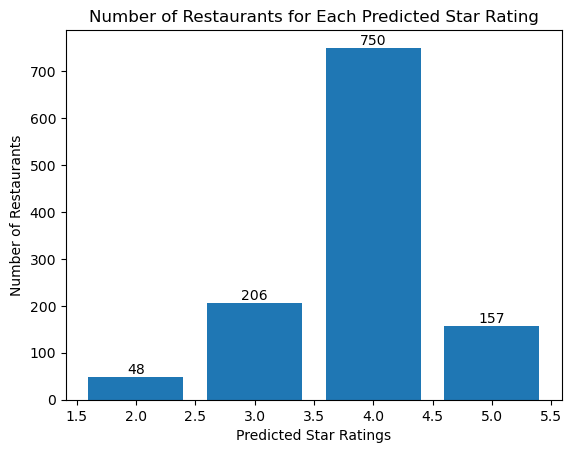

In [42]:
# Count the occurrences of each predicted star rating
rating_counts = predicted_star_rating['Predicted_Star_Rating'].value_counts().sort_index()
bars = plt.bar(rating_counts.index, rating_counts.values)

plt.title('Number of Restaurants for Each Predicted Star Rating')
plt.xlabel('Predicted Star Ratings')
plt.ylabel('Number of Restaurants')

# Display the counts on top of each bar
for bar, count in zip(bars, rating_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha='center', va='bottom')

plt.show()

Note: no restaurants were predicted to be a 1 star rating, which is why it is not present in the graph. 

#### Create a scatter plot to compare stars_x and the predicted star rating

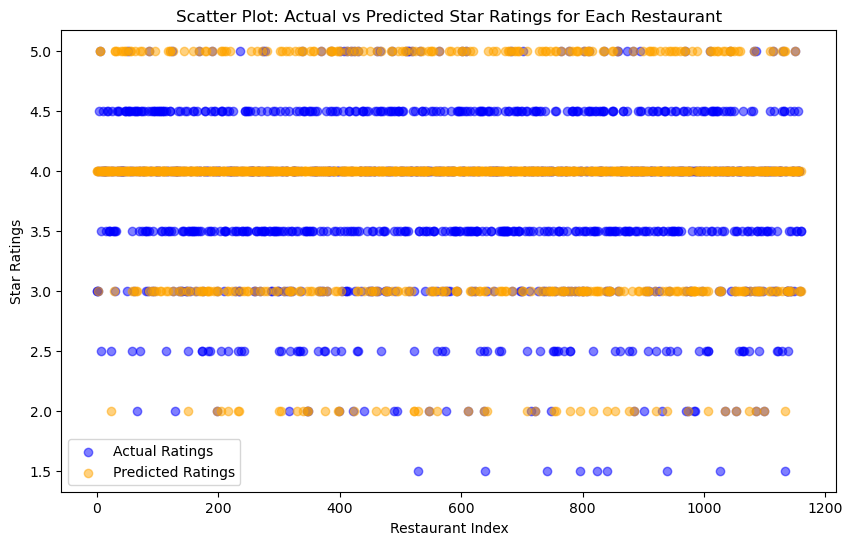

In [43]:
#'predicted_star_rating' is the DataFrame with 'Predicted_Star_Rating' and 'stars_x' columns
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot for actual ratings
ax.scatter(range(len(predicted_star_rating)), predicted_star_rating['stars_x'], label='Actual Ratings', color='blue', alpha=0.5)

# Scatter plot for predicted ratings
ax.scatter(range(len(predicted_star_rating)), predicted_star_rating['Predicted_Star_Rating'], label='Predicted Ratings', color='orange', alpha=0.5)

# Set plot title and labels
ax.set_title('Scatter Plot: Actual vs Predicted Star Ratings for Each Restaurant')
ax.set_xlabel('Restaurant Index')
ax.set_ylabel('Star Ratings')

ax.legend()
plt.show()

It seems that there are not a lot of 100% matches, this is due to the original dataset having values of .5. In the predictive rating, we don't generate the .5 for simplicity (we are focusing on rounding to the nearest whole number). I understand this may skew our results but I wanted to look at this from a general standpoint. However, through the raw numbers we are able to see that the numbers are somewhat close to the original rating values. There was more matches when it does whole number rounding than to the nearest 1st decimal, which is why I approached this way.

### Trying out Multi-Class Classification Method

see if model and accuracy can be improved

In [44]:
#using Random Forest 
X = final_merged[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']]
#y contains the dependent variable (star_y)
y = final_merged['stars_y']  #this is categorical because in the data set, the only options are 1, 2, 3, 4, 5 stars 

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
classification_report_result = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_result)

Accuracy: 0.48970432946145726
Classification Report:
               precision    recall  f1-score   support

           1       0.42      0.49      0.45      4207
           2       0.20      0.16      0.17      3233
           3       0.18      0.10      0.13      4428
           4       0.28      0.22      0.25      9333
           5       0.63      0.75      0.68     20467

    accuracy                           0.49     41668
   macro avg       0.34      0.34      0.34     41668
weighted avg       0.45      0.49      0.46     41668



In [45]:
#using Randomforest with Grid Seach
#note - gridsearch takes a long time to run (at least 25 minutes+)
X = final_merged[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']]
y = final_merged['stars_y']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

#getting the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

#make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, predictions))

KeyboardInterrupt: 

In [46]:
#doing randomForest with K Fold
X = final_merged[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']]
y = final_merged['stars_y']

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation using KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=kf)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy: {:.2f}".format(cv_scores.mean()))

Cross-Validation Scores: [0.48768839 0.49391605 0.49274006 0.49242806 0.49437205]
Mean Accuracy: 0.49


Accuracy is low compared to the other method we tried but will see what kind of predictive ratings this can give

In [47]:
X = final_merged[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']]
y = final_merged['stars_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Label encoding for target variable 'y'
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Choose XGBoost as the model
model = XGBClassifier(n_estimators=100, random_state=42)

#Training the model
model.fit(X_train_scaled, y_train_encoded)
y_pred_encoded = model.predict(X_test_scaled)

# Decode predictions back to original class labels - put it back to  [1, 2, 3, 4, 5]
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5507823749640012

Classification Report:
               precision    recall  f1-score   support

           1       0.44      0.69      0.54      4207
           2       0.27      0.06      0.10      3233
           3       0.19      0.02      0.04      4428
           4       0.32      0.12      0.18      9333
           5       0.61      0.91      0.73     20467

    accuracy                           0.55     41668
   macro avg       0.37      0.36      0.32     41668
weighted avg       0.46      0.55      0.47     41668



In [55]:
#trying to improve model - it improves it slightly but still not better than regression results
X = final_merged[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']]
y = final_merged['stars_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Label encoding for target variable 'y' because of reason above ^ sk-learn classes are expected to start from 0, but our dataset starts from 1
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost model with randomized search for hyperparameter tuning - 
param_dist = {
    'learning_rate': uniform(0.01, 0.2),  #used in the update to prevent overfitting. sampled from the range [0.01, 0.2]
    'n_estimators': randint(100, 300),      #means the number of boosting rounds (trees) to be run.
    'max_depth': randint(3, 6),             #The maximum depth of each tree
    'min_child_weight': randint(1, 4)       #the minimum sum of instance weight (hessian) needed in a child
}

xgb_model = XGBClassifier(random_state=42)
#Random Search CV randomly samples a specified number of combinations from the hyperparameter search space and evaluates the performance using cross-validation
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train_scaled, y_train_encoded)

# #Get the best hyperparameters
# best_params = random_search.best_params_
# print("Best Hyperparameters:", best_params)

#Getting the best model
best_model = random_search.best_estimator_

#Make predictions on the test set
y_pred_encoded = best_model.predict(X_test_scaled)

#Decode predictions back to original class labels - put it back to [1, 2, 3, 4, 5]
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5537342805030239

Classification Report:
               precision    recall  f1-score   support

           1       0.45      0.69      0.54      4207
           2       0.26      0.06      0.09      3233
           3       0.29      0.01      0.02      4428
           4       0.32      0.12      0.17      9333
           5       0.61      0.92      0.73     20467

    accuracy                           0.55     41668
   macro avg       0.38      0.36      0.31     41668
weighted avg       0.47      0.55      0.46     41668



From the results, we can see the acuracy is not that high compared to the other models testing. It is good to test out different models to see if they may be able to yeild a higher accuracy to predict the star rating

In [52]:
#using the same features you used for training the model
#this section is to predict the star rating for each individual review
X_restaurant2 = final_merged[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']]

# Predict star ratings for each restaurant
predicted_ratings2 = best_model.predict(X_restaurant2)

# Create a new DataFrame with the original features and the predicted star ratings
predicted_df2 = final_merged.copy()
predicted_df2['predicted_stars'] = predicted_ratings2

# Display the new DataFrame with original features, actual ratings, and predicted ratings
predicted_df2[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'stars_y', 'predicted_stars']]


,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,stars_y,predicted_stars
0,0.018709,0.018708,0.018709,0.331671,0.018707,0.018710,0.018710,0.018709,0.018709,0.518657,5,4
1,0.027616,0.027610,0.027609,0.027604,0.027608,0.027608,0.027612,0.027607,0.027612,0.751515,5,4
2,0.233617,0.015509,0.015508,0.015508,0.015507,0.015519,0.015507,0.015507,0.015509,0.642310,4,4
3,0.018193,0.018194,0.018198,0.018192,0.018192,0.018191,0.018195,0.018190,0.018194,0.836260,5,4
4,0.026005,0.026003,0.026008,0.025999,0.026004,0.765969,0.026004,0.026002,0.026003,0.026002,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...
208331,0.856581,0.015935,0.015936,0.015934,0.015935,0.015935,0.015935,0.015936,0.015936,0.015935,5,4
208332,0.855354,0.016070,0.016090,0.016066,0.016068,0.016071,0.016074,0.016070,0.016069,0.016070,4,4
208333,0.014911,0.014901,0.865917,0.014893,0.014894,0.014896,0.014897,0.014897,0.014896,0.014899,1,0
208334,0.440240,0.010908,0.010900,0.010898,0.010898,0.472554,0.010899,0.010901,0.010902,0.010900,5,4


In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#run for about 25 mins
X = final_merged[['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10']]
y_individual = final_merged['stars_y']
y_overall = final_merged['stars_x']  # Overall rating for each restaurant

# Train-test split
X_train, X_test, y_train_individual, y_test_individual, y_train_overall, y_test_overall = train_test_split(
    X, y_individual, y_overall, test_size=0.2, random_state=42
)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Define hyperparameter distributions for Random Search
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Random Search with 5-fold cross-validation
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train, y_train_individual)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [None, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42)

In [73]:
# Testing the prediction results in comparison to the original star rating
best_model = random_search.best_estimator_
predicted_ratings_individual = best_model.predict(X_test)

# Create a new DataFrame with the original features, actual individual ratings, and predicted individual ratings
predicted_df = X_test.copy()
predicted_df['business_id'] = final_merged.loc[X_test.index, 'business_id']  # Assuming 'business_id' is a regular column
predicted_df['actual_stars_individual'] = y_test_individual
predicted_df['predicted_stars_individual'] = predicted_ratings_individual

# Merge with final_merged to get 'name_x' column - want to get the business name
predicted_df = pd.merge(predicted_df, final_merged[['business_id', 'name_x']], on='business_id', how='left')

# Aggregate predicted individual ratings to get overall ratings for each restaurant
predicted_df_aggregated = predicted_df.groupby(['business_id', 'name_x'], as_index=False).agg({
    'topic_1': 'mean', 'topic_2': 'mean', 'topic_3': 'mean', 'topic_4': 'mean', 'topic_5': 'mean',
    'topic_6': 'mean', 'topic_7': 'mean', 'topic_8': 'mean', 'topic_9': 'mean', 'topic_10': 'mean',
    'actual_stars_individual': 'mean', 'predicted_stars_individual': 'mean'
})

predicted_df_aggregated

,business_id,name_x,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,actual_stars_individual,predicted_stars_individual
0,-3AooxIkg38UyUdlz5oXdw,Chase Restaurant,0.033350,0.164837,0.333647,0.024306,0.019978,0.047102,0.284243,0.029437,0.031931,0.031169,3.255319,3.308511
1,-8iATYRnN46Km0_-ldx6cg,Pace food+drink,0.159745,0.114184,0.138055,0.080683,0.032952,0.202962,0.122095,0.040994,0.087636,0.020693,4.333333,4.303030
2,-9r8nAzWyRSLxBWt8uQOdA,Hana Kitchen,0.111950,0.092144,0.306409,0.020277,0.317959,0.043130,0.021311,0.029420,0.038976,0.018423,2.969697,3.545455
3,-ALqLSTzkGDMscHdxA1NgA,Su Casa Fresh Mexican Grill,0.027795,0.019665,0.115329,0.031805,0.055039,0.038469,0.019665,0.025697,0.646873,0.019664,4.000000,4.700000
4,-BdYhP-12elmFV7oB1iv4A,Corner Tap Room,0.212368,0.087791,0.085993,0.018172,0.018173,0.307345,0.073088,0.160719,0.018177,0.018174,4.583333,4.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,zeAfmYy9b1gfUJLRBHm6vQ,Presto Pasta,0.155868,0.346773,0.223863,0.019145,0.018026,0.089531,0.072664,0.027081,0.029024,0.018025,3.708333,3.979167
1120,ziXR7sUrbKRCNeDqfjibUg,Rudy's Restaurant No 1,0.041448,0.032310,0.176838,0.019535,0.043596,0.057536,0.035242,0.031293,0.504590,0.057613,3.830189,4.245283
1121,zpuFEeAhrNzXPkOlBf5Kog,Outback Steakhouse,0.038976,0.321620,0.352976,0.023164,0.019345,0.072938,0.108534,0.026520,0.019460,0.016467,3.375000,3.166667
1122,zu4p6IZLSVn2Noto-vcwzw,East Beach Grill,0.024841,0.100112,0.229611,0.016662,0.018115,0.016664,0.020392,0.259545,0.055601,0.258457,3.310345,3.862069
